# Lecture 02 - The Garden of Forking Data

In [1]:
%run init_notebook.py

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

from scipy import stats as stats

from matplotlib import pyplot as plt

Watermark:
----------
Last updated: 2025-05-09T21:42:24.791401+07:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.36.0

Compiler    : Clang 15.0.7 
OS          : Darwin
Release     : 24.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

IPython    : 8.36.0
arviz      : 0.16.1
scipy      : 1.12.0
pymc       : 5.8.0
matplotlib : 3.10.1
statsmodels: 0.14.4
numpy      : 1.25.2
xarray     : 2025.4.0
pandas     : 2.2.3
watermark  : 2.5.0



## Task: What proportion of earth's surface is covered with water?

## Workflow (Drawing the Owl)
1. Define **generative model** of tossing the globe
2. Define an **estimand** -- in this case, the proportion of glove covered in water
3. **Design a statistical procedure** to produce an estimate of the estimand
4. **Validate the statistical procedure** (3) using the generative model -- can we recover an accurate estimate of (2) from data generated by (1)
5. **Apply statistical procedure** (3) to real data

## 1, 2. Define generative model of globe tossing
- $p$: proportion of water -- this is the **estimand**, what we'd like to estimate
- $N$: number of tosses -- we control this via experiment
- $W$: number of `Water` observations
- $L$: number of `Land` observations

In [2]:
utils.draw_causal_graph(
    edge_list = [
        ("p", "W"),
        ("p", "L"),
        ("N", "L"),
        ("N", "W")
    ],
    graph_direction = "LR",
    node_props = {
        "p": {"color": "red"}
    },
    edge_props = {
        ("p", "W"): {"label": "influence"}
    }
)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

- This graph defines a causal model, of how $p, N$ effect the values of $W, L$. This is the same as saying it defines some function $f$ that maps $p, N$ onto the values of $W, L,$ i.e. $W, L = f(p, N)$
- Scientific knowledge defines what $f$ is or can be

The unglamorous basis of applied probability:
> **Things that can happen more ways are more plausible.**

#### Bayesian data analysis
"Very simple, very humble"
- For each possible explanation of the sample
- Count all the ways the sample could occur
- **The explanations with the largest number of ways to produce the observed sample are more plausible**

## 3. Design a statistical procedure to produce an estimate

### Garden of Forking Data

Following the mantra above...
- for each possible **proportion of water,** $p$
- count all the ways the sample of tosses could have occured
- the $p$ that are associated with more ways to produce the sample are more plausible

In [3]:
def calculate_n_ways_possible(observations: str, n_water: int, resolution: int = 4):
    """
    Calculate the number of ways to observing water ('W') given the toss of a globe
    with `resolution` number of sides and `n_water` faces.

    Note: this method results in numerical precision issues (due to the product) when the
    resolution of 16 or so, depending on your system.
    """
    assert n_water <= resolution

    # Convert observation string to an array
    observations = np.array(list(observations.upper()))

    # Create n-sided globe with possible outcomes
    possible = np.array(list("L" * (resolution - n_water)) + list("W" * n_water))

    # Tally up ways to obtain each observation given the possible outcomes
    # Here we use brute-force, but we could also use the analytical solution below
    ways = []
    for obs in observations:
        ways.append((possible == obs).sum())

    p_water = n_water / resolution
    # perform product in log space for numerical precision
    n_ways = np.round(np.exp(np.sum(np.log(ways)))).astype(int)
    return n_ways, p_water

def run_globe_tossing_simulation(observations, resolution, current_n_possible_ways = None):
    """
    Simulate the number of ways you can observe water ('W') for a globe of `resolution`
    sides, varying the proportion of the globe that is covered by water.
    """
    # For Bayesian updates
    current_n_possible_ways = current_n_possible_ways if current_n_possible_ways is not None else np.array([])

    print(f"Observations: '{observations}'")
    p_water = np.array([])
    for n_W in range(0, resolution + 1):
        n_L = resolution - n_W
        globe_sides = "W" * n_W + "L" * n_L
        n_possible_ways, p_water_ = calculate_n_ways_possible(observations, n_water = n_W, resolution = resolution)
        print(f"({n_W + 1}) {globe_sides} p(W) = {p_water_:1.2}\t\t{n_possible_ways} Ways to Produce")

        p_water = np.append(p_water, p_water_)
        current_n_possible_ways = np.append(current_n_possible_ways, n_possible_ways)

    return current_n_possible_ways, p_water

RESOLUTION = 4
observations = "WLW"
n_possible_ways, p_water = run_globe_tossing_simulation(observations, resolution = RESOLUTION)

Observations: 'WLW'
(1) LLLL p(W) = 0.0		0 Ways to Produce
(2) WLLL p(W) = 0.25		3 Ways to Produce
(3) WWLL p(W) = 0.5		8 Ways to Produce
(4) WWWL p(W) = 0.75		9 Ways to Produce
(5) WWWW p(W) = 1.0		0 Ways to Produce


### Bayesian (online) Updating

In [4]:
new_observation_possible_ways, _ = run_globe_tossing_simulation("W", resolution = RESOLUTION)

# Online update
n_possible_ways *= new_observation_possible_ways

print("\nUpdated Possibilities given new observation:")
for ii in range(0, RESOLUTION + 1):
    print(f"({ii+1}) p(W) = {p_water[ii]:1.2}\t\t{n_possible_ways[ii]} Ways to Produce")

Observations: 'W'
(1) LLLL p(W) = 0.0		0 Ways to Produce
(2) WLLL p(W) = 0.25		1 Ways to Produce
(3) WWLL p(W) = 0.5		2 Ways to Produce
(4) WWWL p(W) = 0.75		3 Ways to Produce
(5) WWWW p(W) = 1.0		4 Ways to Produce

Updated Possibilities given new observation:
(1) p(W) = 0.0		0.0 Ways to Produce
(2) p(W) = 0.25		3.0 Ways to Produce
(3) p(W) = 0.5		16.0 Ways to Produce
(4) p(W) = 0.75		27.0 Ways to Produce
(5) p(W) = 1.0		0.0 Ways to Produce


### The whole sample

In [5]:
RESOLUTION = 4
observations = "WLWWWLWLW"
n_W = len(observations.replace("L", ""))
n_L = len(observations) - n_W

n_possible_ways, p_water = run_globe_tossing_simulation(observations, resolution = RESOLUTION)

Observations: 'WLWWWLWLW'
(1) LLLL p(W) = 0.0		0 Ways to Produce
(2) WLLL p(W) = 0.25		27 Ways to Produce
(3) WWLL p(W) = 0.5		512 Ways to Produce
(4) WWWL p(W) = 0.75		729 Ways to Produce
(5) WWWW p(W) = 1.0		0 Ways to Produce


Show that we get identical answrs with the analytical solution

#### Results suggest the Analytical Solution $W, L = (Rp)^W \times (R - Rp)^L$

where $R$ is the number of possible globes, in this case 4

In [6]:
def calculate_analytic_n_ways_possible(p, n_W, n_L, resolution = RESOLUTION):
    """This scales much better than the brute-force method"""
    return (resolution * p) ** n_W * (resolution - resolution * p) ** n_L

analytic_n_possible_ways = np.array([calculate_analytic_n_ways_possible(p, n_W, n_L) for p in p_water])
assert (analytic_n_possible_ways == n_possible_ways).all()

### Probability
- non-negative values that sum to 1
- normalizes large sums by the total counts

Proportion	Ways	Probability
0.0		0	0.00
0.25		27	0.02
0.5		512	0.40
0.75		729	0.57
1.0		0	0.00


Text(0.5, 0, 'proportion water')

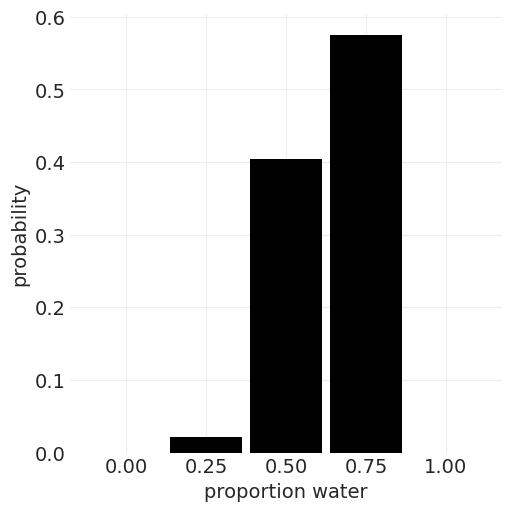

In [7]:
n_possible_probabilities = n_possible_ways / n_possible_ways.sum()

print("Proportion\tWays\tProbability")
for p, n_w, n_p in zip(p_water, n_possible_ways, n_possible_probabilities):
    print(f"{p:1.12}\t\t{n_w:0.0f}\t{n_p:1.2f}")

probs = np.linspace(0, 1, RESOLUTION+1)
plt.subplots(figsize = (5, 5))
plt.bar(x = probs, height = n_possible_probabilities, width = 0.9 / RESOLUTION, color = 'k')
plt.xticks(ticks = probs)
plt.ylabel("probability")
plt.xlabel("proportion water")

## 4. Validate Statistical Procedure (3) using Generative Model (1)

### Test Before You Est(imate)

1. Code generative simulation (1)
2. Code an estimator (3)
3. Test (3) with (1); you should get expected output

**IF YOU TEST NOTHING YOU MISS EVERYTHING**

### 4.1. Generative Simulation

In [8]:
from pprint import pprint
np.random.seed(1)
def simulate_globe_toss(p: float = 0.7, N: int = 9) -> list[str]:
    """
    Simulate N globe tosses with a specific/known proportion
    p: float
        The proportion of water
    N: int
        Number of globe tosses
    """  
    return np.random.choice(list("WL"), size = N, p = np.array([p, 1-p]), replace = True)

In [9]:
print(simulate_globe_toss())

['W' 'L' 'W' 'W' 'W' 'W' 'W' 'W' 'W']


In [10]:
pprint([simulate_globe_toss(p = 1, N = 11).tolist() for _ in range(10)])

[['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W']]


#### Test on Extreme Settings
With a large number of samples N, estimator should converge to known $p$

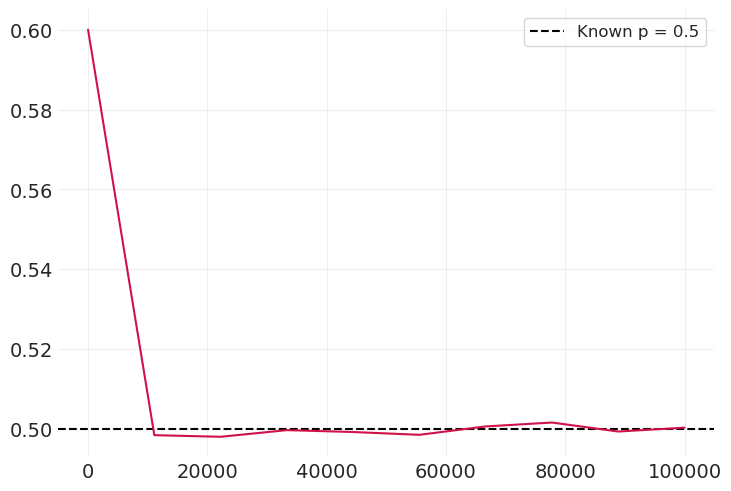

In [11]:
known_p = 0.5

simulated_ps = []
sample_sizes = np.linspace(10, 100_000, 10)
for N in sample_sizes:
    simulated_p = np.sum(simulate_globe_toss(p = known_p, N = int(N)) == "W") / N
    simulated_ps.append(simulated_p)

plt.axhline(known_p, label = f"Known p = {known_p}", color = 'k', linestyle = '--')
plt.legend();
plt.plot(sample_sizes, simulated_ps);

### 4.2. Code the estimator
The estimator takes in observations and returns a probability distribution (posterior) over potential estimates. Higher probability estimates should be more plausible given the data.

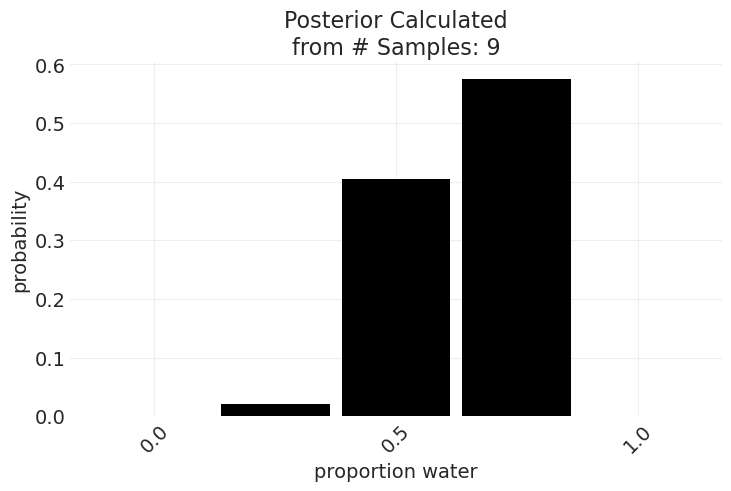

In [15]:
def compute_posterior(observations, resolution = RESOLUTION, ax = None):
    n_W = len(observations.replace("L", ""))
    n_L = len(observations) - n_W
    
    p_water = np.linspace(0, 1, resolution + 1)
    n_possible_ways = np.array([calculate_analytic_n_ways_possible(p, n_W, n_L, resolution) for p in p_water])
    
    posterior = n_possible_ways / n_possible_ways.sum()
    potential_p = np.linspace(0, 1, resolution + 1)
    
    return posterior, potential_p

def plot_posterior(observations, resolution = RESOLUTION, ax = None):
    posterior, probs = compute_posterior(observations, resolution=resolution)
    if ax is not None:
        plt.sca(ax)
    plt.bar(x = probs, height = posterior, width = .9 / resolution, color = 'k')
    plt.xticks(probs[::2], rotation = 45);
    plt.ylabel("probability")
    plt.xlabel("proportion water")
    plt.title(f"Posterior Calculated\nfrom # Samples: {len(observations)}")
    
    
plot_posterior(observations, resolution = 4)

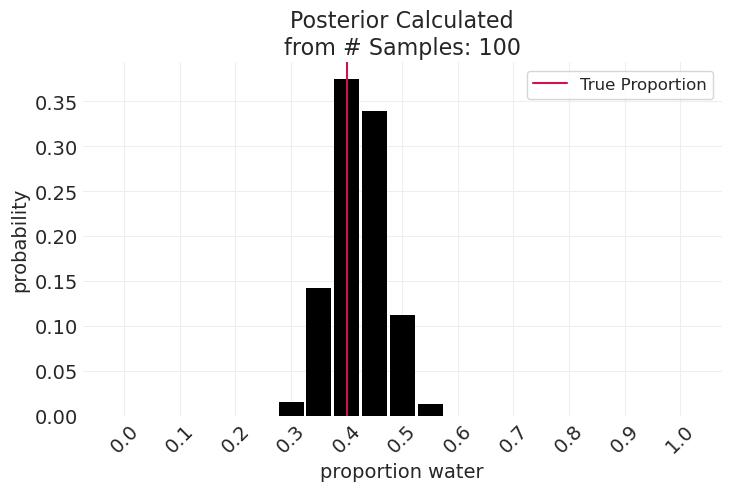

In [16]:
np.random.seed(2)
known_p = .4
simulated_observations = "".join(simulate_globe_toss(p=known_p, N=100))
plot_posterior(simulated_observations, resolution=20)
plt.axvline(known_p, color = 'C0', label = "True Proportion")
plt.legend();